In [ ]:
pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163480 sha256=baff7c0b5b6261d5a232d203bee3a25d15ffea0098df169bd4209b0f52d5f33b
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


Step 1: Load the Movies and their ratings dataset

In [ ]:
import pandas as pd

# Load movie data
movies = pd.read_csv('movies.csv')

# Load ratings data
ratings = pd.read_csv('ratings.csv')


Step 2: Pre-process the dataset

In [ ]:
# Remove duplicates and handle missing values
movies = movies.drop_duplicates()
ratings = ratings.dropna()

# Merge the data
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Create a user-item matrix
user_movie_ratings = movie_ratings.pivot_table(index='userId', columns='title', values='rating')


Step 3: Split the dataset

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)


Step 4: Collaborative filtering algorithm


In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import KNNBasic

# Load the data into the Surprise dataset
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)

# Use a user-based collaborative filtering algorithm
sim_options = {
    'name': 'cosine',
    'user_based': True
}

model = KNNBasic(sim_options=sim_options)
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0033  0.9969  0.9971  0.9980  0.9849  0.9960  0.0060  
MAE (testset)     0.7801  0.7734  0.7724  0.7719  0.7628  0.7721  0.0055  
Fit time          0.16    0.18    0.20    0.17    0.19    0.18    0.01    
Test time         1.05    1.32    1.04    1.06    1.37    1.17    0.15    


{'test_rmse': array([1.00327428, 0.99691005, 0.99713434, 0.99797297, 0.98492669]),
 'test_mae': array([0.78013415, 0.77336792, 0.77242392, 0.77194217, 0.76276666]),
 'fit_time': (0.15692377090454102,
  0.18177103996276855,
  0.19786596298217773,
  0.1704111099243164,
  0.19093060493469238),
 'test_time': (1.04634428024292,
  1.3154079914093018,
  1.0379176139831543,
  1.0585691928863525,
  1.3747825622558594)}

Step 5: Train the model

In [ ]:
# Train the model on the entire training set
trainset = data.build_full_trainset()
model.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


Step 6: Evaluate the model

In [ ]:
testset = Dataset.load_from_df(test_data[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
predictions = model.test(testset)

from surprise import accuracy
accuracy.rmse(predictions)
accuracy.mae(predictions)


RMSE: 0.9727
MAE:  0.7524


0.7524181944441279

Step 7: Make movie recommendations

In [ ]:
def get_top_n_recommendations(predictions, n=10):
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, est))

    # Sort the predictions for each user and retrieve the top N recommendations
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Get top N recommendations for a user (replace 'user_id' with an actual user ID)
user_id = 'user_id'
user_ratings = [(user_id, movie, 4) for movie in movies['title']]
user_predictions = model.test(user_ratings)
top_n_recommendations = get_top_n_recommendations(user_predictions)

print(f"Top 10 Recommendations for User {user_id}: {top_n_recommendations[user_id]}")


Top 10 Recommendations for User user_id: [('Toy Story (1995)', 3.5143762385636816), ('Jumanji (1995)', 3.5143762385636816), ('Grumpier Old Men (1995)', 3.5143762385636816), ('Waiting to Exhale (1995)', 3.5143762385636816), ('Father of the Bride Part II (1995)', 3.5143762385636816), ('Heat (1995)', 3.5143762385636816), ('Sabrina (1995)', 3.5143762385636816), ('Tom and Huck (1995)', 3.5143762385636816), ('Sudden Death (1995)', 3.5143762385636816), ('GoldenEye (1995)', 3.5143762385636816)]


Step 8: Test the model with new user ratings

In [ ]:
# Example new user ratings
new_user_ratings = [('3', 'Toy Story (1995)', 4), ('3', 'Jumanji (1995)', 3.5)]

new_user_predictions = model.test(new_user_ratings)
top_n_recommendations = get_top_n_recommendations(new_user_predictions)

print(f"Top 10 Recommendations for New User: {top_n_recommendations['3']}")


Top 10 Recommendations for New User: [('Toy Story (1995)', 3.5143762385636816), ('Jumanji (1995)', 3.5143762385636816)]


Visualizing the model

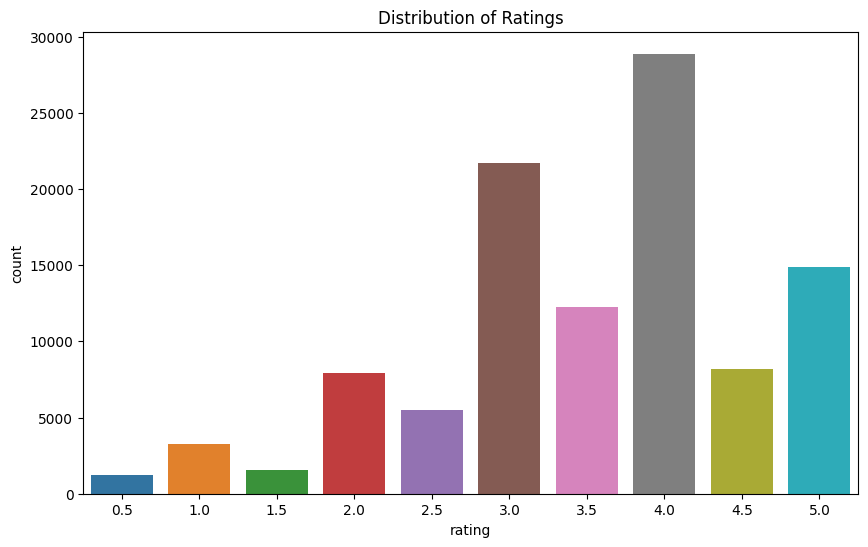

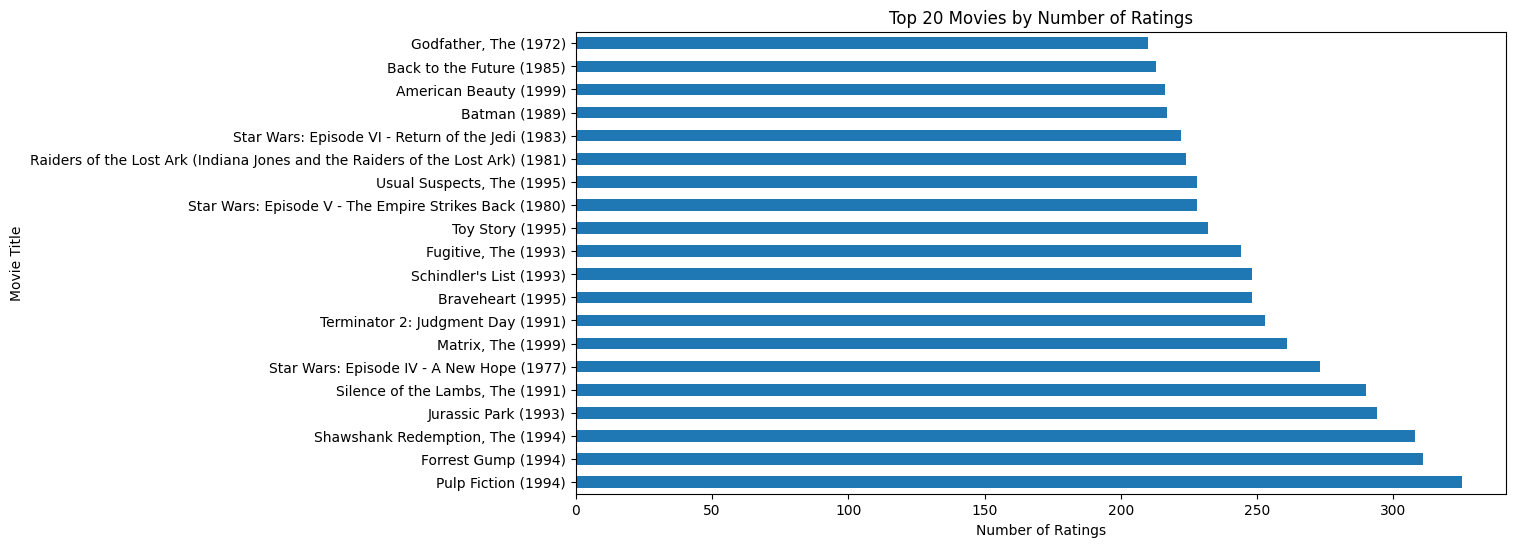

RMSE: 0.9727
MAE:  0.7524


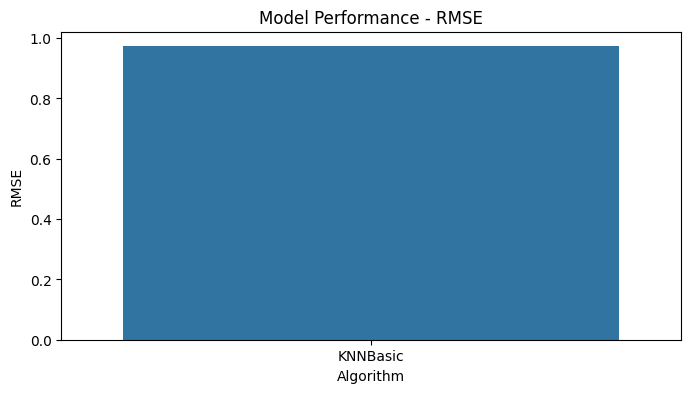

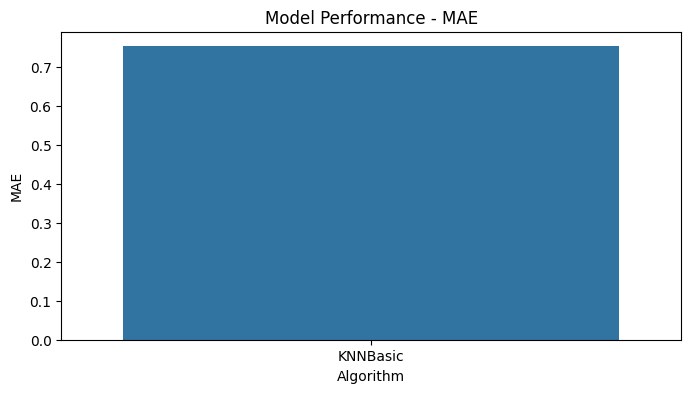

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.show()

# Number of Ratings per Movie
plt.figure(figsize=(12, 6))
movie_ratings.groupby('title')['rating'].count().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 20 Movies by Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()

# Model Performance Metrics
metrics_df = pd.DataFrame({'Algorithm': ['KNNBasic'], 'RMSE': [accuracy.rmse(predictions)], 'MAE': [accuracy.mae(predictions)]})
plt.figure(figsize=(8, 4))
sns.barplot(x='Algorithm', y='RMSE', data=metrics_df)
plt.title('Model Performance - RMSE')
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x='Algorithm', y='MAE', data=metrics_df)
plt.title('Model Performance - MAE')
plt.show()
